# **CP3 2023**

In [1]:
import os
import numpy as np
import torch

from torch.utils.data import DataLoader, TensorDataset
from tqdm import trange
# Clone the repository and move into the directory
if not os.path.exists('CP3_2023'):
    !git clone https://github.com/Lyleregenwetter/CP3_2023.git
%cd CP3_2023/

from utils_public import *


# Load the datasets
topologies = np.load("topologies_train.npy")
constraints = np.load("constraints_train.npy", allow_pickle=True)

# Generate masked topologies using the provided utility function
masked_topologies = []
for i in trange(len(topologies)):
    mask = random_n_masks(np.array((64,64)), 4, 7).astype(bool)
    topology = topologies[i]
    masked_topology = topology * (1 - mask) + 0.5 * (mask)
    masked_topologies.append(masked_topology)
masked_topologies = np.stack(masked_topologies)

masked_constraints = mask_constraints(constraints) #From the utils file


# Prepare tensors and loaders for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_in_tensor = torch.from_numpy(masked_topologies).float().to(device)
data_out_tensor = torch.from_numpy(topologies).float().to(device)
data_in_tensor = data_in_tensor.unsqueeze(1)
data_out_tensor = data_out_tensor.unsqueeze(1)

# Create the DataLoader
train_dataset = TensorDataset(data_in_tensor, data_out_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)


Cloning into 'CP3_2023'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 41 (delta 20), reused 31 (delta 10), pack-reused 0
Receiving objects: 100% (41/41), 10.05 MiB | 2.67 MiB/s, done.
Resolving deltas: 100% (20/20), done.
Updating files: 100% (11/11), done.
/content/CP3_2023


100%|██████████| 12000/12000 [02:13<00:00, 89.84it/s] 


In [2]:
input_channels = 1
image_size = (64, 64)

latent_dim = 10
hidden_size = 64
num_layers = 3
kernel_size = 3
stride = 2
num_epochs = 20
batch_size = 64

# PreTrained U-Net model

## Evaluate models

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
def reconstruct_from_vae(model, masked_topologies, device='cpu'):
    with torch.no_grad():
        data_in = torch.from_numpy(masked_topologies).float()
        data_in = data_in.unsqueeze(1).to(device)
        samples = model(data_in)[0][:,0,:,:].to('cpu').numpy()
        samples = np.round(samples)
    return samples

def binarize_output(output, threshold=0.5):
    return (output > threshold).float()

def plot_reconstruction(originals, masked, reconstructions):
    # Function to plot reconstructed city grids alongside originals
    n = len(originals)
    fig, axes = plt.subplots(nrows=n, ncols=4, figsize=(9, 2*n))
    for i in range(n): # Loop over the grids
        axes[i,0].imshow(masked[i], cmap = "gray") # Plot masked on the left
        axes[i,1].imshow(reconstructions[i], cmap = "gray") # Plot reconstruction on the left
        axes[i,2].imshow(originals[i], cmap = "gray") #Plot originals on the right
        axes[i,3].imshow(originals[i]-reconstructions[i], cmap = "RdBu", vmin=-1, vmax=1) #Plot error on the right
    fig.tight_layout()
    plt.show()
def reconstruct_from_model(model, masked_topologies, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        data_in = torch.from_numpy(masked_topologies).float()
        data_in = data_in.unsqueeze(1).to(device)
        reconstructions = model(data_in)
        reconstructions = binarize_output(reconstructions)
        # If the model outputs a tuple (like VAE does), take the first element
        if isinstance(reconstructions, tuple):
            reconstructions = reconstructions[0]
        reconstructions = reconstructions[:, 0, :, :].cpu().numpy()  # Assuming the channel is the first dimension
        reconstructions = np.clip(reconstructions, 0, 1)  # Ensuring the pixel values are valid
    return reconstructions

def evaluate_score(masked_topologies, original_topologies, reconstructed_topologies):
    masks = masked_topologies==0.5 #Identify the masked regions
    correct = reconstructed_topologies==original_topologies #Identify all correctly predicted pixels
    correct_in_mask = np.logical_and(correct, masks) # Identify all correctly predicted pixels within masked regions
    accuracy_fractions = np.sum(correct_in_mask, axis=(1,2))/np.sum(masks, axis=(1,2)) #(correct & mask)/#(mask) for each topology individually
    average_accuracy_fraction = np.mean(accuracy_fractions) #Average of these ratios across test set
    return average_accuracy_fraction

def evaluate_model(model, device, plot=True):
    # Select random samples for visual comparison
    originals_indices = np.random.choice(np.arange(len(masked_topologies)), size=5, replace=False)
    reconstructions = reconstruct_from_model(model, masked_topologies[originals_indices], device)

    # Load the test datasets
    topologies_test = np.load("topologies_test.npy")
    masked_topologies_test = np.load("masked_topologies_test.npy")

    # Perform reconstruction on the test set
    reconstructions_test = reconstruct_from_model(model, masked_topologies_test, device)

    # Evaluate the reconstruction accuracy
    score = evaluate_score(masked_topologies_test, topologies_test, reconstructions_test)
    print(f"Final Accuracy: {score:.5f}")

    # Plot reconstructions if requested
    if plot:
        plot_reconstruction(topologies[originals_indices], masked_topologies[originals_indices], reconstructions)
    return score


## U-Net with a VGG11 Encoder

In [3]:
pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=0630edf9effe5dd438d1f5af87ff50c83bef1feb134fb56099e1eb06d8fdf4c3
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=f94e8efe7a08ca83c06f29a9c5705361a4a69355dfa3163074eeb0f273286b68
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
import torch.optim as optim

In [40]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

def train_unet(model, train_loader, val_loader, optimizer, num_epochs, patience=4):
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for data_in, data_out in train_loader:
            data_in, data_out = data_in.to(device), data_out.to(device)
            optimizer.zero_grad()
            output = model(data_in)
            loss = nn.functional.mse_loss(output, data_out)
            #loss = combined_loss(output,data_out)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data_in, data_out in val_loader:
                data_in, data_out = data_in.to(device), data_out.to(device)
                output = model(data_in)
                val_loss += nn.functional.mse_loss(output, data_out).item()
                #val_loss = combined_loss(output,data_out).item()

        val_loss /= len(val_loader)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f'Early stopping after {epoch + 1} epochs')
            break

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss}')




Epoch 1/100, Train Loss: 2.632748158154976, Val Loss: 0.033079415979519695
Epoch 2/100, Train Loss: 7.0238129570290395, Val Loss: 0.09536271028115716
Epoch 3/100, Train Loss: 5.699551374246711, Val Loss: 0.1956761857153664
Epoch 4/100, Train Loss: 9.973217032402227, Val Loss: 0.14788838507423938
Epoch 5/100, Train Loss: 9.63670601356156, Val Loss: 0.1777471085669289
Epoch 6/100, Train Loss: 7.423250673516479, Val Loss: 0.11096480866553078
Epoch 7/100, Train Loss: 6.637492486529132, Val Loss: 0.10300510701998858
Early stopping after 8 epochs
Final Accuracy: 0.71540


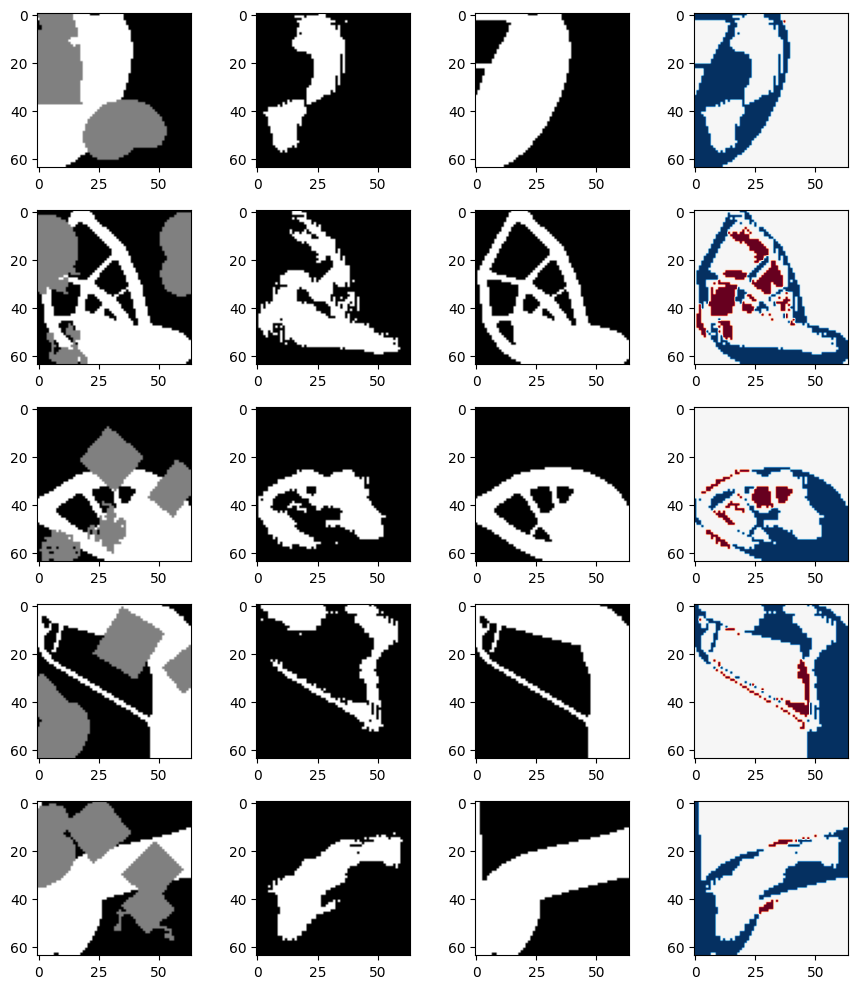

0.7154045436963602

In [37]:
batch_size = 34
lr = 0.009

# Load pre-trained U-Net model with VGG11 encoder
model34 = smp.Unet('vgg11', encoder_weights='imagenet', in_channels=1, classes=1, activation=None).to(device)

# Define the optimizer
optimizer = optim.Adam(model34.parameters(), lr=lr)

# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data_in_tensor, data_out_tensor, test_size=0.2)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

train_unet(model34, train_loader, val_loader, optimizer, num_epochs=100)
evaluate_model(model34, device)

Epoch 1/100, Train Loss: 0.06089739443423847, Val Loss: 0.027628521881997586
Epoch 2/100, Train Loss: 0.024073618507633607, Val Loss: 0.021940090488642455
Epoch 3/100, Train Loss: 0.01952408853918314, Val Loss: 0.019504554197192193
Epoch 4/100, Train Loss: 0.016621881170819204, Val Loss: 0.017757565081119538
Epoch 5/100, Train Loss: 0.014201310256806514, Val Loss: 0.01587090900167823
Epoch 6/100, Train Loss: 0.012087975531661263, Val Loss: 0.015125624959667523
Epoch 7/100, Train Loss: 0.010656670962149898, Val Loss: 0.014537736177444457
Epoch 8/100, Train Loss: 0.009566372589518627, Val Loss: 0.014053601700191697
Epoch 9/100, Train Loss: 0.008544287338542442, Val Loss: 0.014121475896487634
Epoch 10/100, Train Loss: 0.007777758580632507, Val Loss: 0.013499611330529054
Epoch 11/100, Train Loss: 0.0072541687746221824, Val Loss: 0.013515939122686784
Epoch 12/100, Train Loss: 0.0066118323465343565, Val Loss: 0.013344277509798606
Epoch 13/100, Train Loss: 0.006145724939027181, Val Loss: 0.01

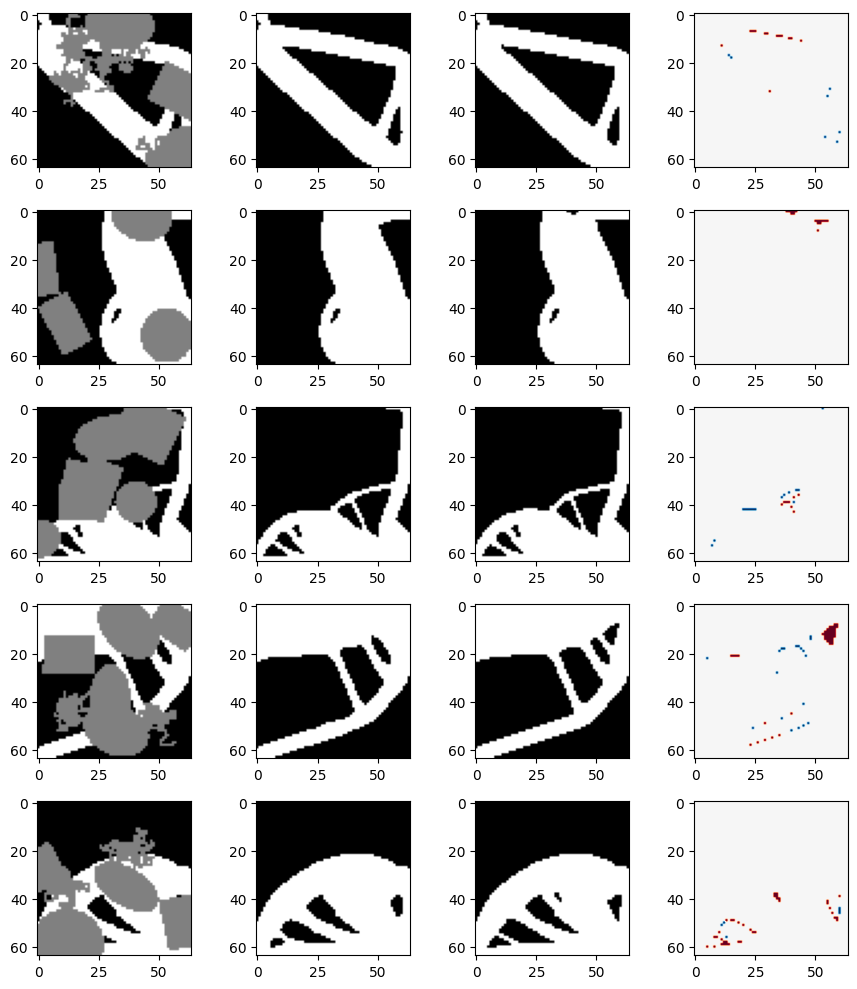

0.9783359692038391

In [41]:
batch_size = 16
lr = 0.0003

# Load pre-trained U-Net model with VGG11 encoder
model16 = smp.Unet('vgg11', encoder_weights='imagenet', in_channels=1, classes=1, activation=None).to(device)

# Define the optimizer
optimizer = optim.Adam(model16.parameters(), lr=lr)

# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data_in_tensor, data_out_tensor, test_size=0.2)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

train_unet(model16, train_loader, val_loader, optimizer, num_epochs=100)
evaluate_model(model16, device)

Final Accuracy: 0.97823


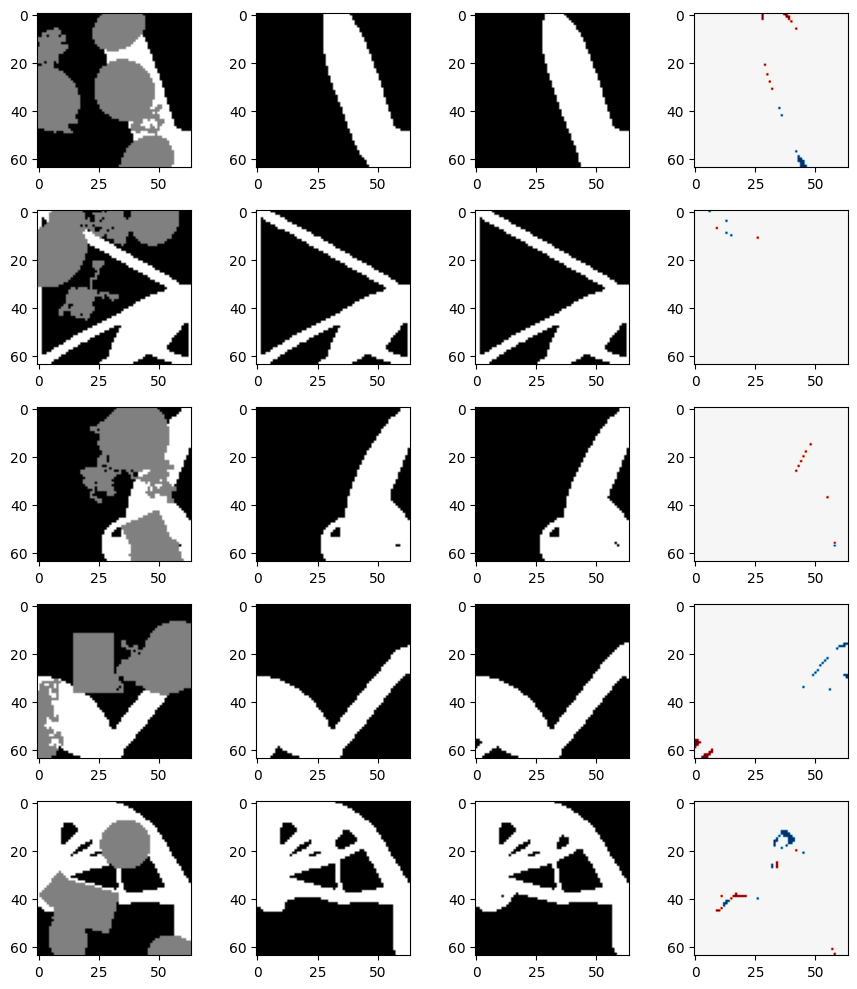

0.9782284536636336

### Data Augmentation

In [ ]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import random

class CustomDataset(Dataset):
    def __init__(self, data_tensor, target_tensor, transform=None):
        self.data_tensor = data_tensor
        self.target_tensor = target_tensor
        self.transform = transform

    def __len__(self):
        return len(self.data_tensor)

    def __getitem__(self, idx):
        data = self.data_tensor[idx]
        target = self.target_tensor[idx]

        if self.transform:
            data = self.transform(data)

        return data, target

# Define your transforms specifically for grid data
def grid_transform(image):
    # Apply random flip and 90-degree rotation
    if random.random() > 0.5:
        image = transforms.functional.vflip(image)
    if random.random() > 0.5:
        image = transforms.functional.hflip(image)
    #rotations = [0, 90, 180, 270]
    #angle = random.choice(rotations)
    #image = transforms.functional.rotate(image, angle)
    return image

transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert tensor to PIL Image
    grid_transform,  # Apply grid-specific transform
    transforms.ToTensor()  # Convert back to tensor
])

# Create instances of CustomDataset with transforms for training data
train_dataset = CustomDataset(X_train, y_train, transform=transform)
val_dataset = CustomDataset(X_val, y_val, transform=None)  # No transform for validation data

# Create DataLoader instances
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
train_unet(model, train_loader, val_loader, optimizer, num_epochs=100)

Epoch 1/100, Train Loss: 0.224500679175059, Val Loss: 0.17703497252966227
Epoch 2/100, Train Loss: 0.21207576622565588, Val Loss: 0.15940384566783905
Epoch 3/100, Train Loss: 0.2068078699707985, Val Loss: 0.15529966432797282
Epoch 4/100, Train Loss: 0.20403463423252105, Val Loss: 0.1685992236200132
Epoch 5/100, Train Loss: 0.201440815726916, Val Loss: 0.19076518714427948
Epoch 6/100, Train Loss: 0.19928203771511713, Val Loss: 0.14360281981919942
Epoch 7/100, Train Loss: 0.1964619415998459, Val Loss: 0.17355974685204656
Epoch 8/100, Train Loss: 0.19368040601412456, Val Loss: 0.1613625146840748
Epoch 9/100, Train Loss: 0.19151485443115235, Val Loss: 0.17145179839510666
Epoch 10/100, Train Loss: 0.18807247658570608, Val Loss: 0.140738925847568
Epoch 11/100, Train Loss: 0.18663231939077377, Val Loss: 0.15992197982574763
Epoch 12/100, Train Loss: 0.1837644835313161, Val Loss: 0.15623540588115392
Epoch 13/100, Train Loss: 0.18068828215201696, Val Loss: 0.1645389689426673
Epoch 14/100, Train 

Final Accuracy: 0.75237


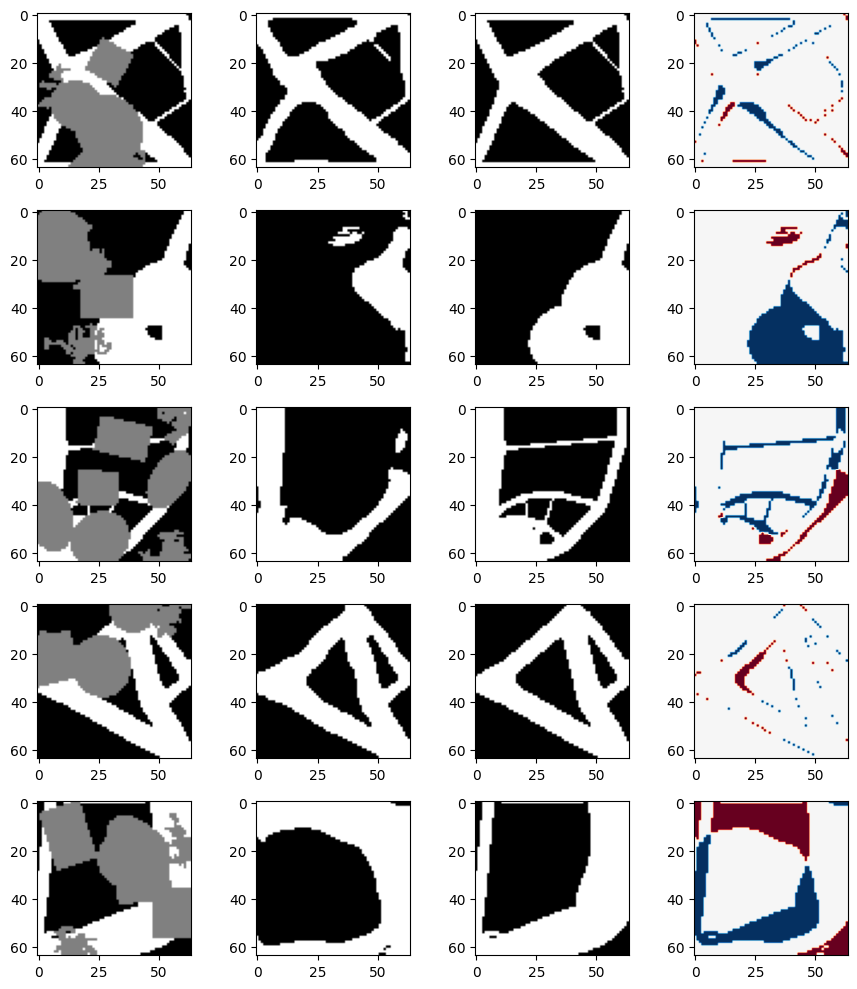

0.7523720203984564

In [ ]:
evaluate_model(model, device)

### Combined Lossfunction

In [13]:
def dice_loss(output, target, epsilon=1e-6):
    numerator = 2 * (output * target).sum(dim=(2, 3))  # sum over the height and width dimensions
    denominator = (output + target).sum(dim=(2, 3))  # sum over the height and width dimensions
    dice = numerator / (denominator + epsilon)  # add epsilon to avoid division by zero
    return 1 - dice.mean()  # average over the batch

def combined_loss(output, target):
    mse_loss = nn.functional.mse_loss(output, target)
    d_loss = dice_loss(output, target)
    return mse_loss + d_loss


In [ ]:
def train_unet_comb_loss(model, train_loader, val_loader, optimizer, num_epochs, patience=5):
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for data_in, data_out in train_loader:
            data_in, data_out = data_in.to(device), data_out.to(device)
            optimizer.zero_grad()
            output = model(data_in)
            loss = combined_loss(output, data_out)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data_in, data_out in val_loader:
                data_in, data_out = data_in.to(device), data_out.to(device)
                output = model(data_in)
                val_loss += combined_loss(output, data_out).item()
        val_loss /= len(val_loader)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f'Early stopping after {epoch + 1} epochs')
            break

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss}')


In [ ]:
# Load pre-trained U-Net model with VGG11 encoder
model = smp.Unet('vgg11', encoder_weights='imagenet', in_channels=1, classes=1, activation=None).to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data_in_tensor, data_out_tensor, test_size=0.2)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

train_unet(model, train_loader, val_loader, optimizer, num_epochs=50)

Epoch 1/100, Train Loss: 0.08104017809033394, Val Loss: 0.031089623164581626
Epoch 2/100, Train Loss: 0.02732467041661342, Val Loss: 0.024076450076934538
Epoch 3/100, Train Loss: 0.022326414523025355, Val Loss: 0.021182775252351637
Epoch 4/100, Train Loss: 0.01954228359585007, Val Loss: 0.019519898844392675
Epoch 5/100, Train Loss: 0.017503973835458358, Val Loss: 0.018139429537481384
Epoch 6/100, Train Loss: 0.015747464758654437, Val Loss: 0.017380290909817343
Epoch 7/100, Train Loss: 0.01436791945869724, Val Loss: 0.016841411051389418
Epoch 8/100, Train Loss: 0.01302564690510432, Val Loss: 0.015308772679418325
Epoch 9/100, Train Loss: 0.012022278811782599, Val Loss: 0.015558802375667974
Epoch 10/100, Train Loss: 0.010916362246498466, Val Loss: 0.014176505740339818
Epoch 11/100, Train Loss: 0.010150681001444657, Val Loss: 0.014137168635467165
Epoch 12/100, Train Loss: 0.009377654064446688, Val Loss: 0.013732287297515492
Epoch 13/100, Train Loss: 0.00871899130443732, Val Loss: 0.0134704

TypeError: ignored

### Optimize hyperparameters: lr, batch_size and optimizer_type/name

In [ ]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.2 MB/s eta 0:00:00


In [ ]:
import optuna
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
import torch.optim as optim

def objective(trial):
    # Hyperparameters to tune
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])

    # Model setup
    model = smp.Unet('vgg11', encoder_weights='imagenet', in_channels=1, classes=1, activation=None).to(device)

    # Optimizer setup
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # Data loading
    X_train, X_val, y_train, y_val = train_test_split(data_in_tensor, data_out_tensor, test_size=0.2)
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

    # Training and validation loop
    best_val_loss = float('inf')
    for epoch in range(num_epochs):  # Define NUM_EPOCHS as a constant or pass it as a parameter
        model.train()
        train_loss = 0
        for data_in, data_out in train_loader:
            data_in, data_out = data_in.to(device), data_out.to(device)
            optimizer.zero_grad()
            output = model(data_in)
            loss = nn.functional.mse_loss(output, data_out)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data_in, data_out in val_loader:
                data_in, data_out = data_in.to(device), data_out.to(device)
                output = model(data_in)
                val_loss += nn.functional.mse_loss(output, data_out).item()
        val_loss /= len(val_loader)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
        else:
            break  # Early stopping

    return best_val_loss

# Example of running the hyperparameter optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Best trial:', study.best_trial.params)


[I 2023-11-19 00:12:31,985] A new study created in memory with name: no-name-5efd4996-d23e-4cf9-98e7-393bdaf7bc14
[I 2023-11-19 00:16:01,217] Trial 0 finished with value: 0.026566319117943445 and parameters: {'lr': 0.00562641585940627, 'batch_size': 32, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.026566319117943445.
[I 2023-11-19 00:18:54,487] Trial 1 finished with value: 0.03718064154187838 and parameters: {'lr': 1.1544559759827833e-05, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.026566319117943445.
[I 2023-11-19 00:23:16,282] Trial 2 finished with value: 0.019225395235576127 and parameters: {'lr': 0.00020235179684928195, 'batch_size': 128, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.019225395235576127.
[I 2023-11-19 00:26:38,467] Trial 3 finished with value: 0.017681890508780877 and parameters: {'lr': 0.08064744812355604, 'batch_size': 16, 'optimizer': 'SGD'}. Best is trial 3 with value: 0.017681890508780877.
[I 2023-11-19 00:28:51,145] Trial 

Best trial: {'lr': 0.000926444903134056, 'batch_size': 32, 'optimizer': 'Adam'}


In [ ]:
best_params = study.best_trial.params

# Data loading
X_train, X_val, y_train, y_val = train_test_split(data_in_tensor, data_out_tensor, test_size=0.2)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(dataset=train_dataset, batch_size= best_params['batch_size'], shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size= best_params['batch_size'], shuffle=False)


# Model setup
model = smp.Unet('vgg11', encoder_weights='imagenet', in_channels=1, classes=1, activation=None).to(device)

# Optimizer setup
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])

# Data loading
train_unet(model, train_loader, val_loader, optimizer, num_epochs=50)

Epoch 1/50, Train Loss: 0.05455559420709809, Val Loss: 0.02746587445338567
Epoch 2/50, Train Loss: 0.02324315467849374, Val Loss: 0.02139547516902288
Epoch 3/50, Train Loss: 0.018749908295770487, Val Loss: 0.018442942487696807
Epoch 4/50, Train Loss: 0.016353313211972514, Val Loss: 0.0174447122340401
Epoch 5/50, Train Loss: 0.014442422700424989, Val Loss: 0.016470785103738308
Epoch 6/50, Train Loss: 0.012867658672233422, Val Loss: 0.015007424565653005
Epoch 7/50, Train Loss: 0.011819136369352539, Val Loss: 0.014797038560112318
Epoch 8/50, Train Loss: 0.01064681265503168, Val Loss: 0.013935151485105355
Epoch 9/50, Train Loss: 0.009742367030121386, Val Loss: 0.014147180492679278
Epoch 10/50, Train Loss: 0.008960050547805925, Val Loss: 0.013442826929191748
Epoch 11/50, Train Loss: 0.008272897062512736, Val Loss: 0.013300292653342089
Epoch 12/50, Train Loss: 0.007624915572814643, Val Loss: 0.012797160670161248
Epoch 13/50, Train Loss: 0.007081243524638315, Val Loss: 0.012731679982195298
Ep

Final Accuracy: 0.97823


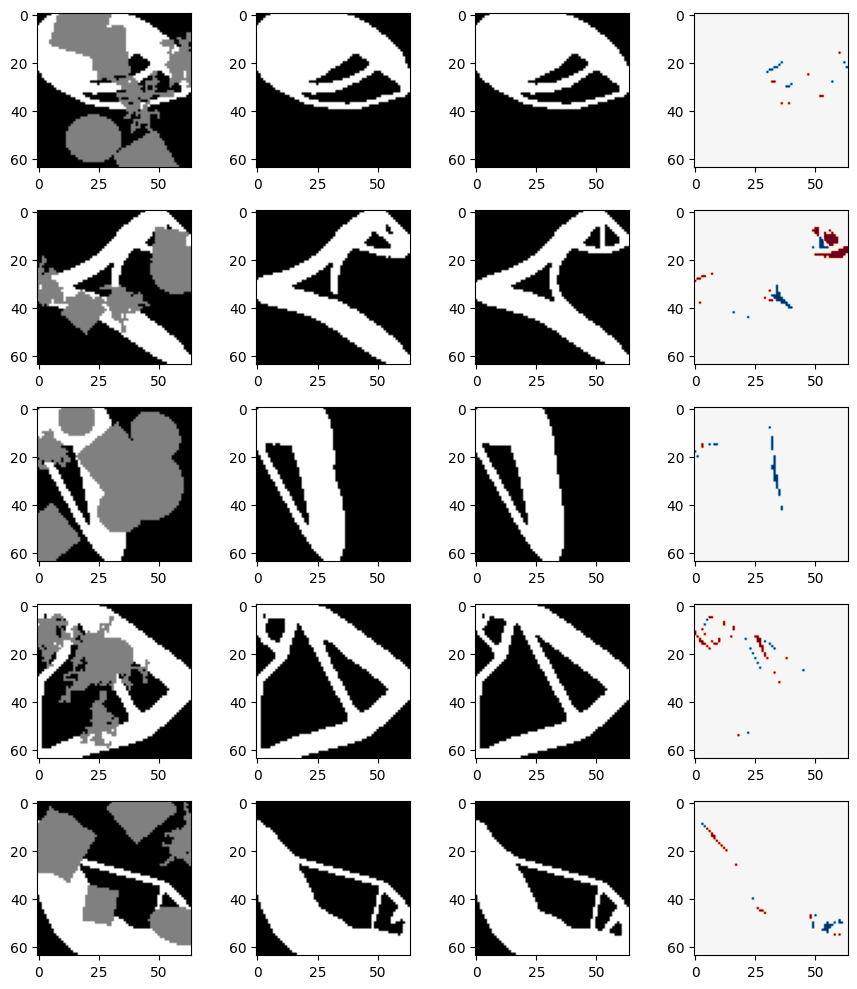

0.9782284536636336

In [20]:
evaluate_model(model, device)

### Different encoders - NOT TESTED

In [ ]:
import segmentation_models_pytorch as smp

def create_unet_with_encoder(encoder_name='resnet34', in_channels=1, classes=1, encoder_weights='imagenet'):
    """
    Create a U-Net model with the specified encoder.

    :param encoder_name: Name of the encoder. Options include 'resnet34', 'efficientnet-b0', 'mobilenet_v2', etc.
    :param in_channels: Number of input channels.
    :param classes: Number of classes for segmentation.
    :param encoder_weights: Pretrained weights for the encoder. Use 'imagenet' or None.
    :return: U-Net model with the specified encoder.
    """
    model = smp.Unet(
        encoder_name=encoder_name,
        encoder_weights=encoder_weights,
        in_channels=in_channels,
        classes=classes,
        activation=None
    )
    return model

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet34 = create_unet_with_encoder('resnet34').to(device)
model_efficientnet = create_unet_with_encoder('efficientnet-b0').to(device)
# Add more models as needed


Epoch 1/100, Train Loss: 0.14863894452961782, Val Loss: 0.05896568484604359
Epoch 2/100, Train Loss: 0.044049351631353297, Val Loss: 0.05006741856535276
Epoch 3/100, Train Loss: 0.03664260823279619, Val Loss: 0.05564000147084395
Epoch 4/100, Train Loss: 0.03264969990899166, Val Loss: 0.05397141880045334
Epoch 5/100, Train Loss: 0.029123527424720425, Val Loss: 0.030704671051353216
Epoch 6/100, Train Loss: 0.02648952044546604, Val Loss: 0.03336712500701348
Epoch 7/100, Train Loss: 0.02428455518869062, Val Loss: 0.02545786602422595
Epoch 8/100, Train Loss: 0.022538972087204456, Val Loss: 0.022424733266234398
Epoch 9/100, Train Loss: 0.021466266868325572, Val Loss: 0.024320388057579596
Epoch 10/100, Train Loss: 0.020413145151299734, Val Loss: 0.02054171698788802
Epoch 11/100, Train Loss: 0.01903945840119074, Val Loss: 0.019574543926864862
Epoch 12/100, Train Loss: 0.018380275306602318, Val Loss: 0.02024778661628564
Epoch 13/100, Train Loss: 0.017488820711150765, Val Loss: 0.019030465899656

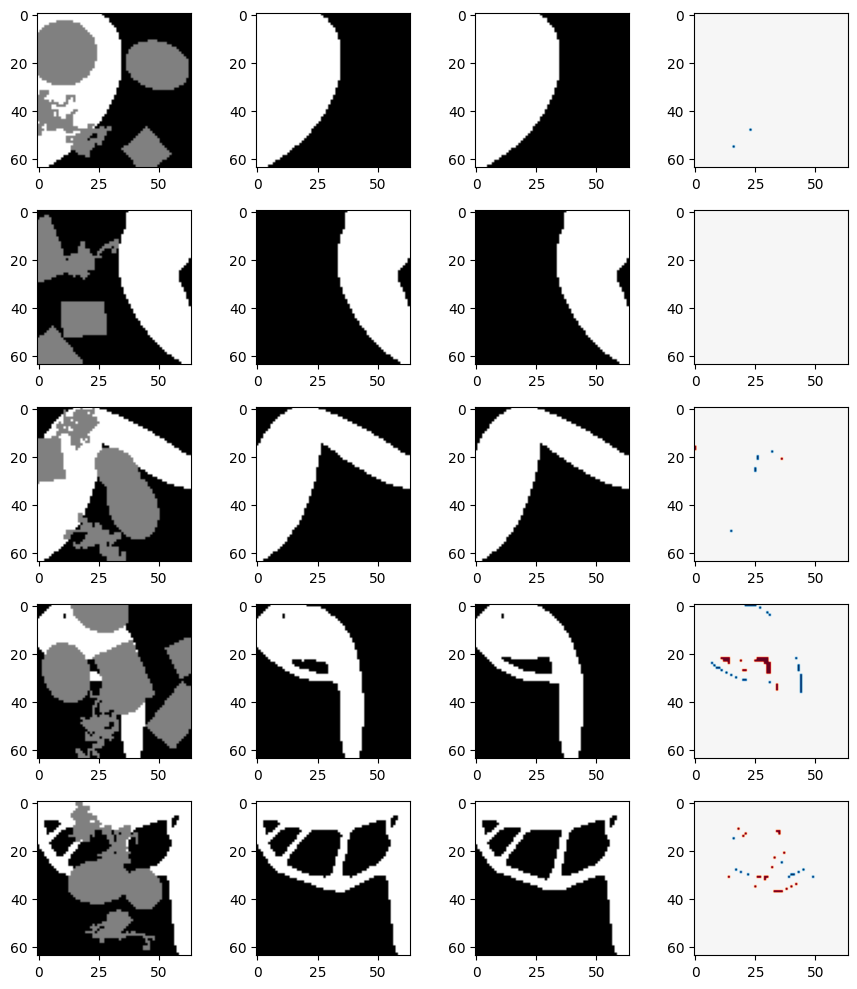

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 222MB/s]


Epoch 1/100, Train Loss: 0.10161940606000523, Val Loss: 0.050230044250686966
Epoch 2/100, Train Loss: 0.042177520925179124, Val Loss: 0.0747661953791976
Epoch 3/100, Train Loss: 0.03434291575103998, Val Loss: 0.029228356666862965
Epoch 4/100, Train Loss: 0.029723643131243687, Val Loss: 0.027734681653479736
Epoch 5/100, Train Loss: 0.026984602639762063, Val Loss: 0.02572079251209895
Epoch 6/100, Train Loss: 0.024706248853666086, Val Loss: 0.022925972162435453
Epoch 7/100, Train Loss: 0.022380784736014903, Val Loss: 0.022929045526931684
Epoch 8/100, Train Loss: 0.02039868027592699, Val Loss: 0.031907493248581886
Epoch 9/100, Train Loss: 0.019855143657575052, Val Loss: 0.018801075251152117
Epoch 10/100, Train Loss: 0.01790590388312315, Val Loss: 0.01755990119030078
Epoch 11/100, Train Loss: 0.016539252285535138, Val Loss: 0.017299070643881958
Epoch 12/100, Train Loss: 0.016222494091683377, Val Loss: 0.016803896753117442
Epoch 13/100, Train Loss: 0.01530614912432308, Val Loss: 0.0285906041

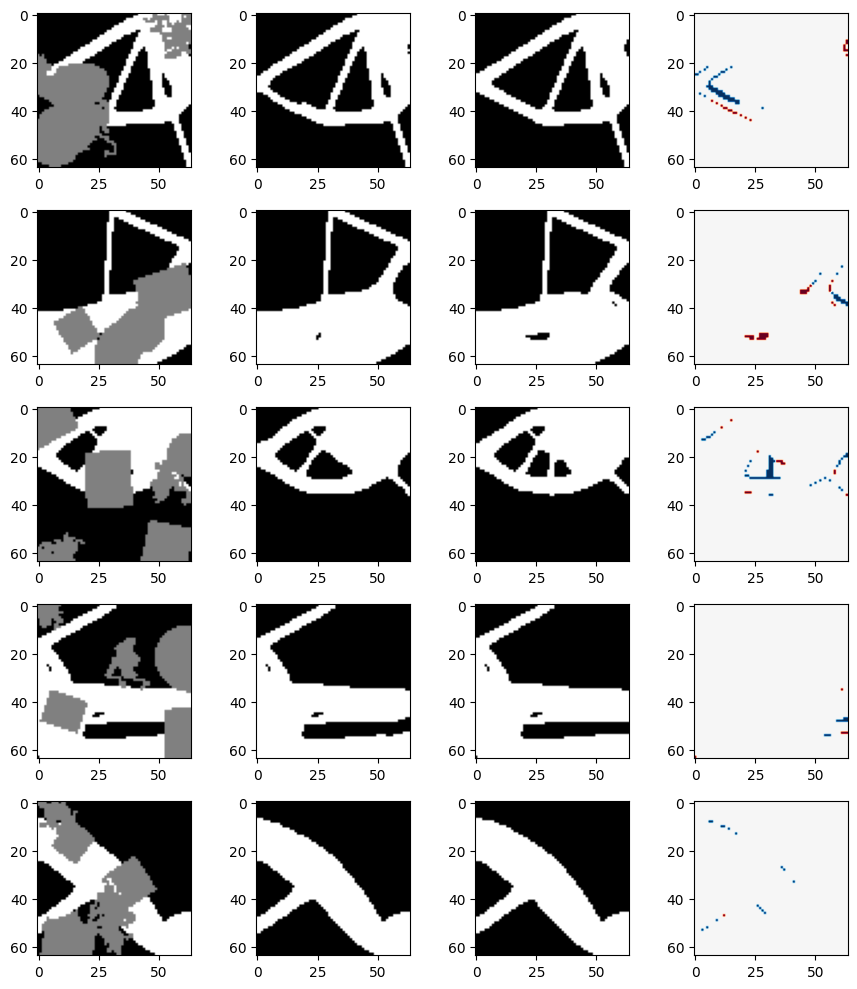

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 52.8MB/s]


Epoch 1/100, Train Loss: 0.15292709142280123, Val Loss: 0.2516940546532472
Epoch 2/100, Train Loss: 0.05493358778767288, Val Loss: 0.05204595718532801
Epoch 3/100, Train Loss: 0.04531439758526782, Val Loss: 0.04604646066824595
Epoch 4/100, Train Loss: 0.037423733117369316, Val Loss: 0.03822699096053839
Epoch 5/100, Train Loss: 0.03341990903330346, Val Loss: 0.030815694325913984
Epoch 6/100, Train Loss: 0.03102843218948692, Val Loss: 0.04695444988707701
Epoch 7/100, Train Loss: 0.029020109757160146, Val Loss: 0.02856990850220124
Epoch 8/100, Train Loss: 0.027074250237395365, Val Loss: 0.030086446087807417
Epoch 9/100, Train Loss: 0.02578009428301205, Val Loss: 0.024623313453048468
Epoch 10/100, Train Loss: 0.023710737742173176, Val Loss: 0.022644471066693466
Epoch 11/100, Train Loss: 0.023330973694100976, Val Loss: 0.021208881090084713
Epoch 12/100, Train Loss: 0.02195331050703923, Val Loss: 0.02237744287898143
Epoch 13/100, Train Loss: 0.02012344729155302, Val Loss: 0.01935862889513373

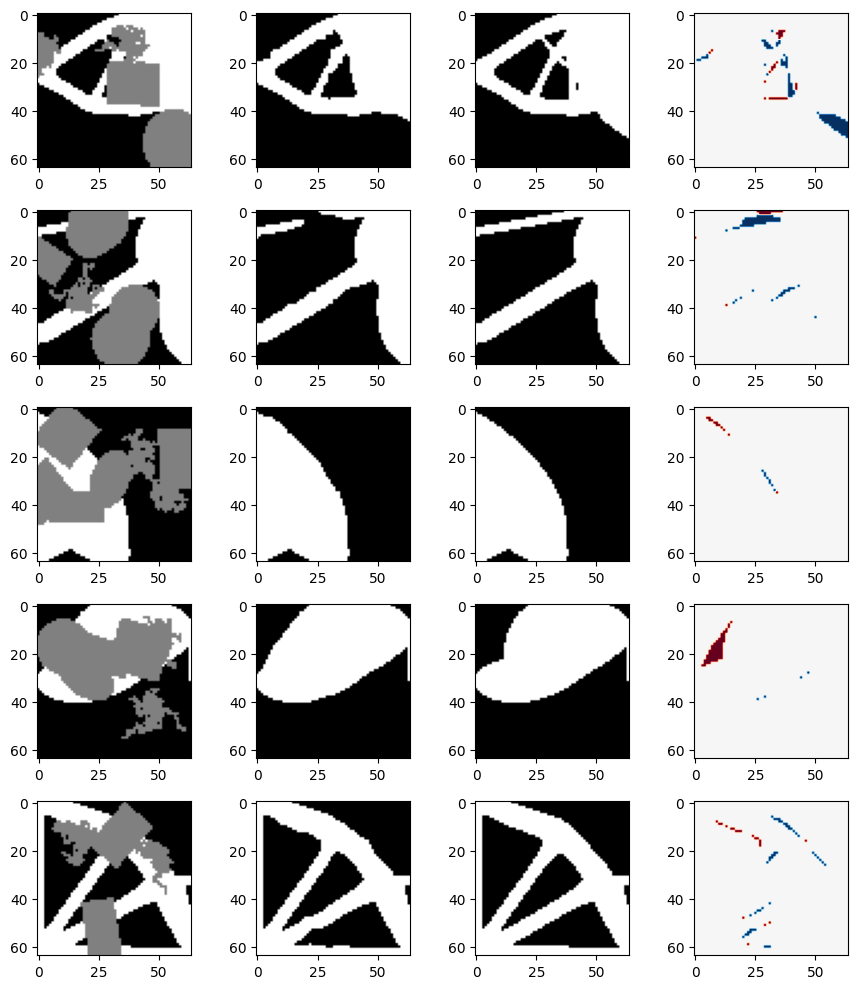

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 72.9MB/s]


Epoch 1/100, Train Loss: 0.09185308388744791, Val Loss: 124604497.33333333
Epoch 2/100, Train Loss: 0.031680328849082194, Val Loss: 1260.1644388834636
Epoch 3/100, Train Loss: 0.025436429229254525, Val Loss: 0.05306258766601483
Epoch 4/100, Train Loss: 0.021864823764190078, Val Loss: 0.03215440254037579
Epoch 5/100, Train Loss: 0.019092344562523067, Val Loss: 0.02810376634200414
Epoch 6/100, Train Loss: 0.01723847850613917, Val Loss: 0.027995169162750244
Epoch 7/100, Train Loss: 0.01601753003584842, Val Loss: 0.026122751800964277
Epoch 8/100, Train Loss: 0.014640840177889913, Val Loss: 0.021642754940936964
Epoch 9/100, Train Loss: 0.013723542777976641, Val Loss: 0.0188200194388628
Epoch 10/100, Train Loss: 0.012633003643713892, Val Loss: 0.01853531723221143
Epoch 11/100, Train Loss: 0.012028532354937246, Val Loss: 0.017465388712783653
Epoch 12/100, Train Loss: 0.011385793196192632, Val Loss: 0.016243478438506525
Epoch 13/100, Train Loss: 0.011544664739631116, Val Loss: 0.01742675900459

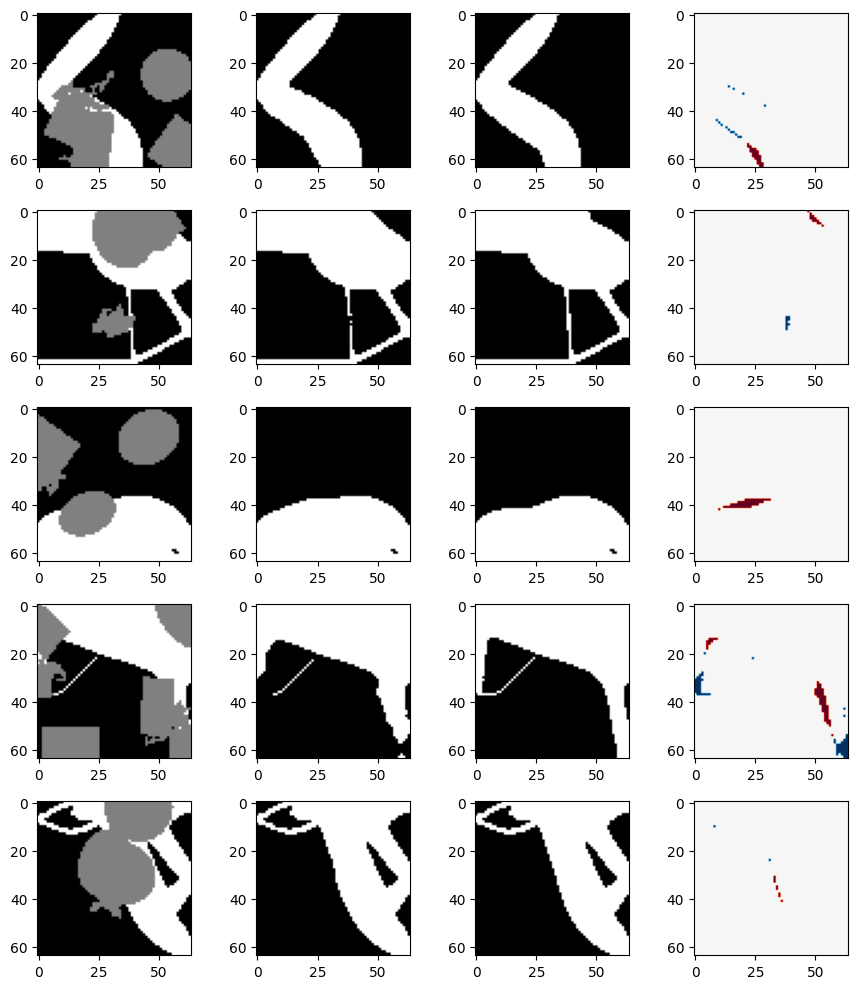

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/densenet121-fbdb23505.pth" to /root/.cache/torch/hub/checkpoints/densenet121-fbdb23505.pth


URLError: ignored

In [ ]:
import segmentation_models_pytorch as smp
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

def create_unet_model(encoder_type, lr=0.009):
    model = smp.Unet(encoder_type, encoder_weights='imagenet', in_channels=1, classes=1, activation=None).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    return model, optimizer


def train_and_evaluate(model, train_loader, val_loader, optimizer):
    train_unet(model, train_loader, val_loader, optimizer, num_epochs=100)
    metrics = evaluate_model(model, device)

    return metrics


encoders = ['vgg11', 'resnet34', 'mobilenet_v2', 'efficientnet-b0', 'densenet121']
batch_size = 16
lr = 0.009

# Split your data
X_train, X_val, y_train, y_val = train_test_split(data_in_tensor, data_out_tensor, test_size=0.2)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# Store metrics for each encoder
encoder_metrics = {}

for encoder in encoders:
    model, optimizer = create_unet_model(encoder, lr)
    metrics = train_and_evaluate(model, train_loader, val_loader, optimizer)
    encoder_metrics[encoder] = metrics

# Now encoder_metrics contains performance metrics for each encoder


# Add Constraints as input

In [ ]:
# Augment dataset
import torchvision.transforms as transforms

# Define the transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90)
])

In [6]:
import numpy as np
import torch
from scipy.sparse import csr_matrix

In [7]:
def preprocess_constraints(masked_constraints):
    processed_constraints = []

    for row in masked_constraints:
        constraint_tensors = []
        for constraint in row:
            if constraint is None:
                # Replace None with a zero-filled tensor
                processed_constraint = torch.zeros((64, 64), dtype=torch.float32)
            elif isinstance(constraint, csr_matrix):
                # Convert sparse matrix to dense numpy array and then to tensor
                dense_array = constraint.toarray().astype(np.float32)
                processed_constraint = torch.from_numpy(dense_array)
            else:
                # Handle the floating-point number, reshape it to 64x64 tensor
                float_constraint = np.full((64, 64), constraint, dtype=np.float32)
                processed_constraint = torch.from_numpy(float_constraint)

            constraint_tensors.append(processed_constraint)

        # Stack all constraints for this row
        processed_constraints.append(torch.stack(constraint_tensors))

    # Stack all rows to form a single tensor
    return torch.stack(processed_constraints)


preprocessed_constraints = preprocess_constraints(masked_constraints)

In [8]:
from sklearn.model_selection import train_test_split

# Generate indices for splitting
indices = np.arange(len(data_in_tensor))
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

# Use the indices to split the image data
X_train = data_in_tensor[train_indices]
X_val = data_in_tensor[val_indices]
y_train = data_out_tensor[train_indices]
y_val = data_out_tensor[val_indices]

# Use the same indices to split the constraints
constraints_train = preprocessed_constraints[train_indices]
constraints_val = preprocessed_constraints[val_indices]





In [9]:


def prepare_input(image_tensor, constraint_tensor, device):
    # Convert numpy arrays to PyTorch tensors if they are not already
    if isinstance(image_tensor, np.ndarray):
        image_tensor = torch.from_numpy(image_tensor).float()

    if isinstance(constraint_tensor, np.ndarray):
        # Check if the constraint_tensor is of type numpy.object_
        if constraint_tensor.dtype == np.object:
            # Process each element in the constraint_tensor
            processed_constraints = []
            for constraint in constraint_tensor:
                if constraint is None:
                    # Replace None with a tensor filled with -1
                    processed_constraint = torch.full((64, 64), -1, dtype=torch.float32)

                    # Replace None with a zero-filled tensor
                    # processed_constraint = torch.zeros((64, 64), dtype=torch.float32)
                elif isinstance(constraint, np.ndarray):
                    # Convert numpy arrays to tensors
                    processed_constraint = torch.from_numpy(constraint).float()
                else:
                    # Add additional handling for other types if necessary
                    raise TypeError(f"Unsupported constraint type: {type(constraint)}")
                processed_constraints.append(processed_constraint)
            constraint_tensor = torch.stack(processed_constraints)
        else:
            constraint_tensor = torch.from_numpy(constraint_tensor).float()

    # Move tensors to the specified device
    image_tensor = image_tensor.to(device)
    constraint_tensor = constraint_tensor.to(device)

    # Ensure both tensors have the same number of dimensions
    # Add channel dimension if missing
    if image_tensor.ndim == 3:
        image_tensor = image_tensor.unsqueeze(1)
    if constraint_tensor.ndim == 3:
        constraint_tensor = constraint_tensor.unsqueeze(1)

    # Ensure both tensors have the same batch size
    if image_tensor.shape[0] != constraint_tensor.shape[0]:
        raise ValueError("Mismatch in batch size of image_tensor and constraint_tensor")

    # Concatenate along the channel dimension
    return torch.cat([image_tensor, constraint_tensor], dim=1)



# Prepare combined inputs for training and validation
X_combined_train = prepare_input(X_train, constraints_train, device)
X_combined_val = prepare_input(X_val, constraints_val, device)


In [10]:
from torch.utils.data import TensorDataset, DataLoader

# Create datasets
train_dataset = TensorDataset(X_combined_train, y_train)
val_dataset = TensorDataset(X_combined_val, y_val)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)


In [12]:
import segmentation_models_pytorch as smp
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Adjust the U-Net model for 6 input channels
model2 = smp.Unet('vgg11', encoder_weights='imagenet', in_channels=6, classes=1, activation=None).to(device)

# Define the optimizer
lr = 0.0009
optimizer = optim.Adam(model2.parameters(), lr=lr)

# Train the model (assuming train_unet is your training function)
train_unet(model2, train_loader, val_loader, optimizer, num_epochs=100)



Epoch 1/100, Train Loss: 0.05330742433046301, Val Loss: 0.02870569422841072
Epoch 2/100, Train Loss: 0.02411237847059965, Val Loss: 0.02160501793026924
Epoch 3/100, Train Loss: 0.01949313747075697, Val Loss: 0.018412060054639974
Epoch 4/100, Train Loss: 0.01686275112753113, Val Loss: 0.01658330362290144
Epoch 5/100, Train Loss: 0.014985666821400324, Val Loss: 0.016087954218188923
Epoch 6/100, Train Loss: 0.01332535366838177, Val Loss: 0.015442267147203287
Epoch 7/100, Train Loss: 0.012141735727588336, Val Loss: 0.01390634906788667
Epoch 8/100, Train Loss: 0.010920501098347206, Val Loss: 0.013486311286687851
Epoch 9/100, Train Loss: 0.010044524824867646, Val Loss: 0.013090216529866059
Epoch 10/100, Train Loss: 0.009366486502500871, Val Loss: 0.013001711529990037
Epoch 11/100, Train Loss: 0.008706211859049896, Val Loss: 0.012356048698226612
Epoch 12/100, Train Loss: 0.008021091382640103, Val Loss: 0.012796449462572733
Epoch 13/100, Train Loss: 0.007578907048640152, Val Loss: 0.0121444973

In [16]:
def reconstruct_from_modelv2(model, combined_inputs, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Ensure the combined inputs are in the correct format and on the right device
        if isinstance(combined_inputs, np.ndarray):
            combined_inputs = torch.from_numpy(combined_inputs).float()
        combined_inputs = combined_inputs.to(device)

        # Perform the reconstruction
        reconstructions = model(combined_inputs)

        # Apply binarization if necessary (assuming a threshold of 0.5)
        reconstructions = binarize_output(reconstructions)

        # If the model outputs a tuple (like VAE does), take the first element
        if isinstance(reconstructions, tuple):
            reconstructions = reconstructions[0]

        # Assuming the channel is the first dimension, move the reconstructed images to CPU and convert to numpy
        reconstructions = reconstructions[:, 0, :, :].cpu().numpy()

        # Ensure the pixel values are within the valid range
        reconstructions = np.clip(reconstructions, 0, 1)

    return reconstructions


In [17]:
def evaluate_model_v2(model, device, masked_topologies, constraints, plot=True):
    model.eval()  # Set the model to evaluation mode

     # Select random samples for visual comparison
    originals_indices = np.random.choice(np.arange(len(masked_topologies)), size=5, replace=False)
    prepocess_const = preprocess_constraints(constraints)
    # Prepare the combined inputs for the validation set
    combined_inputs = prepare_input(masked_topologies[originals_indices], prepocess_const[originals_indices], device)

    # Perform reconstruction on the validation set
    reconstructions = reconstruct_from_modelv2(model, combined_inputs, device)


    # Load the test datasets
    topologies_test = np.load("topologies_test.npy")
    masked_topologies_test = np.load("masked_topologies_test.npy")
    masked_constraints_test = np.load("masked_constraints_test.npy",allow_pickle=True)

    #constraints_test = np.load("constraints_test.npy")  # Load the constraints for the test set

    preprocessed_constraints_test = preprocess_constraints(masked_constraints_test)

    # Prepare the entire test dataset with constraints
    combined_inputs_test = prepare_input(masked_topologies_test, preprocessed_constraints_test, device)

    # Perform reconstruction on the entire test set
    reconstructions_test = reconstruct_from_modelv2(model, combined_inputs_test, device)

    # Evaluate the reconstruction accuracy
    score = evaluate_score(masked_topologies_test, topologies_test, reconstructions_test)
    print(f"Final Accuracy: {score:.5f}")

    # Plot reconstructions if requested
    if plot:
        plot_reconstruction(topologies[originals_indices], masked_topologies[originals_indices], reconstructions)
    return score


Final Accuracy: 0.97851


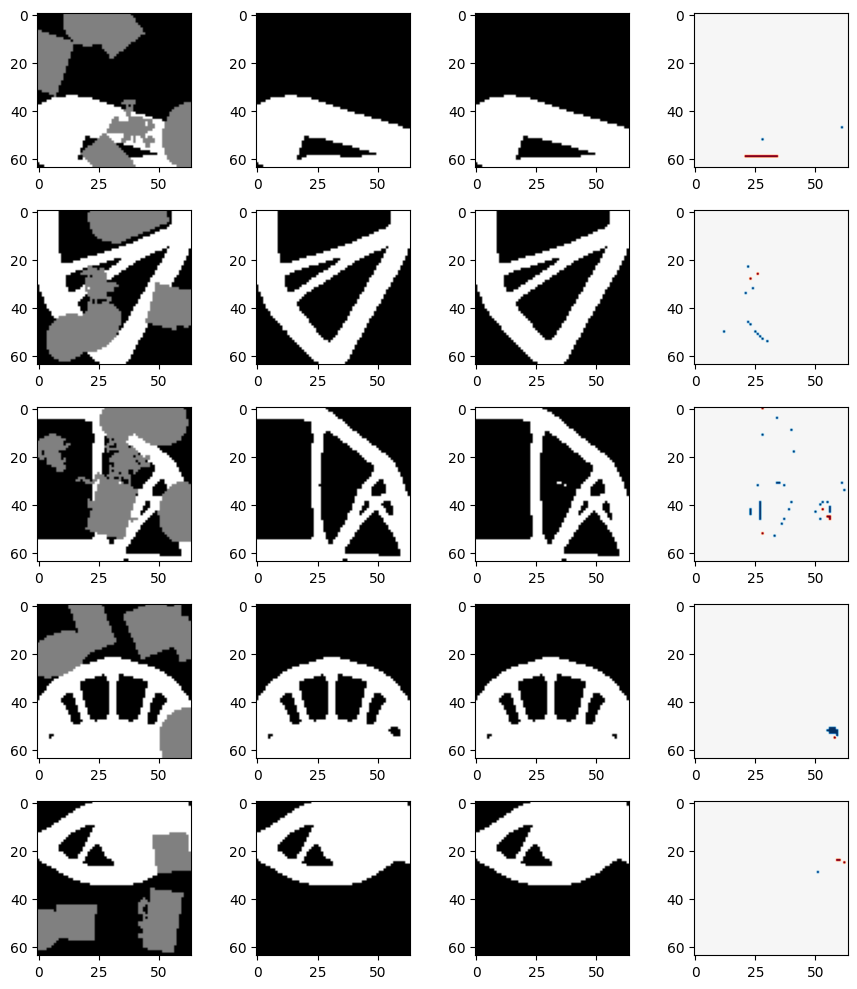

0.9785078463938288

In [21]:
evaluate_model_v2(model2, device, masked_topologies, constraints)

# CNN for predicting the masked Constraints - TODO

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim

class ConstraintPredictionModel(nn.Module):
    def __init__(self):
        super(ConstraintPredictionModel, self).__init__()
        # Define your CNN architecture here
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Add more layers as needed
        self.fc1 = nn.Linear(64 * 16 * 16, 512)  # Adjust the input features size according to your architecture
        self.fc2 = nn.Linear(512, 64 * 64)  # Output size should match the constraint's size

    def forward(self, x):
        # Define the forward pass
        x = nn.ReLU()(self.conv1(x))
        x = nn.ReLU()(self.conv2(x))
        # Add more layers as needed
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layer
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x.view(-1, 64, 64)  # Reshape the output to match the constraint's size





In [74]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch

class ConstraintPredictionDataset(Dataset):
    def __init__(self, reconstructed_topologies, actual_constraints):
        self.reconstructed_topologies = reconstructed_topologies
        self.actual_constraints = actual_constraints

    def __len__(self):
        return len(self.reconstructed_topologies)

    def __getitem__(self, idx):
        topology = self.reconstructed_topologies[idx]
        constraint = self.actual_constraints[idx]

        # Convert to PyTorch tensors
        topology_tensor = torch.tensor(topology, dtype=torch.float32)
        constraint_tensor = torch.tensor(constraint, dtype=torch.float32)

        return topology_tensor, constraint_tensor

# Load your data
# Assuming reconstructed_topologies and actual_constraints are numpy arrays
reconstructed_topologies = reconstructions
actual_constraints = np.load("constraints_train.npy", allow_pickle=True)

# Create dataset
dataset = ConstraintPredictionDataset(reconstructed_topologies, actual_constraints)

# Split the dataset into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# Assuming you have a DataLoader for your dataset
# train_loader = DataLoader(...)

model = ConstraintPredictionModel().to(device)
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    for data in train_loader:
        inputs, targets = data  # inputs are reconstructed topology images, targets are actual constraints
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

# Improving topology images

In [ ]:
import segmentation_models_pytorch as smp

class TopologyRefinementModel(nn.Module):
    def __init__(self):
        super(TopologyRefinementModel, self).__init__()
        # U-Net model with 2 input channels (reconstructed topology + predicted constraints)
        self.unet = smp.Unet(encoder_name="resnet34", in_channels=2, classes=1)

    def forward(self, x):
        return self.unet(x)


In [ ]:
# Assuming you have a DataLoader for your dataset
# refinement_train_loader = DataLoader(...)

refinement_model = TopologyRefinementModel().to(device)
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(refinement_model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    for data in refinement_train_loader:
        inputs, targets = data  # inputs are combined reconstructed topology and predicted constraints
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = refinement_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()


### **Starter Code: VAE**
We have provided you some starter code in which we attempt to reconstruct the original topologies using a Variational Autoencoder (VAE). Below, we define the VAE model and a train loop function.

Note: This code does NOT make use of constraints.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

class VAE(nn.Module): #Create VAE class inheriting from pytorch nn Module class
    def __init__(self, input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride):
        super(VAE, self).__init__()

        # Create encoder model
        self.encoder = Encoder(input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride)

        #Create decoder after calculating input size for decoder
        decoder_input_size = self.calculate_decoder_input_size(image_size, num_layers, kernel_size, stride)
        self.decoder = Decoder(input_channels, hidden_size, num_layers, latent_dim, decoder_input_size, kernel_size, stride, image_size)

    def calculate_decoder_input_size(self, image_size, num_layers, kernel_size, stride):
        #Function to calculate the input size of the decoder given its architecture
        h, w = image_size
        for _ in range(num_layers):
            h = (h - kernel_size) // stride + 1
            w = (w - kernel_size) // stride + 1
        return h, w

    def reparameterize(self, mu, logvar):
        #Sample from gaussian
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x_in):
        #Pass through encoder, reparameterize using mu and logvar as given by the encoder, then pass through decoder
        mu, logvar = self.encoder(x_in)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

class Encoder(nn.Module): #Encoder model of VAE
    def __init__(self, input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride):
        super(Encoder, self).__init__()

        layers = []
        h, w = image_size
        in_channels = input_channels
        for _ in range(num_layers): # Loop over layers, adding conv2d, layernorm, and relu.
            h = (h - kernel_size) // stride + 1 #Update h and w to compensate for previous layers output
            w = (w - kernel_size) // stride + 1
            layers.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, hidden_size, kernel_size, stride),
                    nn.LayerNorm([hidden_size, h, w]),
                    nn.ReLU()             #LeakyReLU, ELU, or SELU
                )
            )
            in_channels = hidden_size #Input channels to later conv layers will just be the hidden size

        self.conv_layers = nn.ModuleList(layers) #Collect convolution layers and layernorm in conv_layers object
        self.final_flatten_size = h * w * hidden_size #Calculate size of final FC output layer
        self.fc_mu = nn.Linear(self.final_flatten_size, latent_dim) #Final FC layer to output mean
        self.fc_logvar = nn.Linear(self.final_flatten_size, latent_dim) #Final FC layer to output logvar

    def forward(self, x): #Forward call for encoder
        for layer in self.conv_layers: #Call conv layers sequentially
            x = layer(x)
        x = x.view(x.size(0), -1) #Flatten x
        mu = self.fc_mu(x) #Get mu and logvar from FC layers
        logvar = self.fc_logvar(x)
        return mu, logvar #Return mu and logvar


class Decoder(nn.Module):  #Decoder model of VAE
    def __init__(self, output_channels, hidden_size, num_layers, latent_dim, decoder_input_size, kernel_size, stride, image_size):
        super(Decoder, self).__init__()
        self.decoder_input_size = decoder_input_size
        self.hidden_size = hidden_size

        #Initial fully connected layer
        self.fc = nn.Linear(latent_dim, hidden_size * decoder_input_size[0] * decoder_input_size[1])
        layers = []
        h, w = decoder_input_size
        for layer_num in range(num_layers-1): # Loop over layers, adding conv2dtranspose, layernorm, and relu.
            next_h, next_w = self.calc_size_layer(layer_num, num_layers, kernel_size, stride, image_size) #Calculate the size of the output of the layer
            output_padding_h = next_h - kernel_size - stride*(h-1) #Calculate the output padding to ensure the output size is correct
            output_padding_w = next_w - kernel_size - stride*(w-1)
            layers.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_size, hidden_size, kernel_size, stride),
                    nn.ReplicationPad2d((0,output_padding_w,0, output_padding_h)),
                    nn.LayerNorm([hidden_size, next_h, next_w]),
                    nn.ReLU()
                )
            )
            h,w = next_h, next_w

        self.deconv_layers = nn.ModuleList(layers) #Collect deconv layers

        next_h, next_w = image_size

        output_padding_h = next_h - kernel_size - stride*(h-1) #Calculate the output padding to ensure the output size is correct
        output_padding_w = next_w - kernel_size - stride*(w-1)
        #Final layer brings the image to the original size
        self.final_layer = nn.Sequential(nn.ConvTranspose2d(hidden_size, output_channels, kernel_size, stride),
                                        nn.ReplicationPad2d((0,output_padding_w,0, output_padding_h)))
    def calc_size_layer(self, layer_num, num_layers, kernel_size, stride, image_size):
        #Function to calculate the number of channels for a given layer
        h, w = image_size
        for _ in range(num_layers-layer_num-1):
            h = (h - kernel_size) // stride + 1
            w = (w - kernel_size) // stride + 1
        return h,w


    def forward(self, z):
        z = self.fc(z) #Call initial FC layer
        z = z.view(z.size(0), self.hidden_size, self.decoder_input_size[0], self.decoder_input_size[1])  # Reshape to match the deconvolution input shape
        for layer in self.deconv_layers: #Sequentially call deconv layers
            z = layer(z)
        z = self.final_layer(z)
        return torch.sigmoid(z) #Final sigmoid layer

def loss_function(recon_x, x_out, mu, logvar):
    # VAE loss is a sum of KL Divergence regularizing the latent space and reconstruction loss
    BCE = nn.functional.binary_cross_entropy(recon_x, x_out, reduction='sum') # Reconstruction loss from Binary Cross Entropy
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) #KL Divergence loss
    return BCE + KLD

def train(epoch, data_in_tensor, data_out_tensor): #Train function for one epoch of training
    model.train()
    train_loss = 0
    num_batches = len(data_in_tensor) // batch_size

    #Tqdm progress bar object contains a list of the batch indices to train over
    progress_bar = tqdm(range(num_batches), desc='Epoch {:03d}'.format(epoch), leave=False, disable=False)

    for batch_idx in progress_bar: #Loop over batch indices
        start_idx = batch_idx * batch_size
        end_idx = (batch_idx + 1) * batch_size
        data_in = data_in_tensor[start_idx:end_idx] #Gather corresponding data
        data_out = data_out_tensor[start_idx:end_idx] #Gather corresponding data


        optimizer.zero_grad() #Set up optimizer
        recon_batch, mu, logvar = model(data_in) #Call model
        loss = loss_function(recon_batch, data_out, mu, logvar) #Call loss function
        loss.backward() #Get gradients of loss
        train_loss += loss.item() #Append to total loss
        optimizer.step() #Update weights using optimizeer

        # Updating the progress bar
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item())})

    average_train_loss = train_loss / len(data_in_tensor) #Calculate average train loss
    tqdm.write('Epoch: {} \tTraining Loss: {:.3f}'.format(epoch, average_train_loss))

We prepare the training data:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Check if gpu/tpu is available

data_in_tensor = torch.from_numpy(masked_topologies).float().to(device)
data_out_tensor = torch.from_numpy(topologies).float().to(device)

#expand dims of tensor in channel 1
data_in_tensor = data_in_tensor.unsqueeze(1)
data_out_tensor = data_out_tensor.unsqueeze(1)

Set up some hyperparameters:

### Optuna

In [ ]:
pip install optuna

In [ ]:
class VAE_optuna(nn.Module): #Create VAE class inheriting from pytorch nn Module class
    def __init__(self, input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride):
        super(VAE_optuna, self).__init__()

        # Create encoder model
        self.encoder = Encoder(input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride)

        #Create decoder after calculating input size for decoder
        decoder_input_size = self.calculate_decoder_input_size(image_size, num_layers, kernel_size, stride)
        self.decoder = Decoder(input_channels, hidden_size, num_layers, latent_dim, decoder_input_size, kernel_size, stride, image_size)

    def calculate_decoder_input_size(self, image_size, num_layers, kernel_size, stride):
        #Function to calculate the input size of the decoder given its architecture
        h, w = image_size
        for _ in range(num_layers):
            h = (h - kernel_size) // stride + 1
            w = (w - kernel_size) // stride + 1
        return h, w

    def reparameterize(self, mu, logvar):
        #Sample from gaussian
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x_in):
        #Pass through encoder, reparameterize using mu and logvar as given by the encoder, then pass through decoder
        mu, logvar = self.encoder(x_in)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

class Encoder(nn.Module): #Encoder model of VAE
    def __init__(self, input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride):
        super(Encoder, self).__init__()

        layers = []
        h, w = image_size
        in_channels = input_channels
        for _ in range(num_layers): # Loop over layers, adding conv2d, layernorm, and relu.
            h = (h - kernel_size) // stride + 1 #Update h and w to compensate for previous layers output
            w = (w - kernel_size) // stride + 1
            layers.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, hidden_size, kernel_size, stride),
                    nn.LayerNorm([hidden_size, h, w]),
                    nn.ReLU()             #LeakyReLU, ELU, or SELU
                )
            )
            in_channels = hidden_size #Input channels to later conv layers will just be the hidden size

        self.conv_layers = nn.ModuleList(layers) #Collect convolution layers and layernorm in conv_layers object
        self.final_flatten_size = h * w * hidden_size #Calculate size of final FC output layer
        self.fc_mu = nn.Linear(self.final_flatten_size, latent_dim) #Final FC layer to output mean
        self.fc_logvar = nn.Linear(self.final_flatten_size, latent_dim) #Final FC layer to output logvar

    def forward(self, x): #Forward call for encoder
        for layer in self.conv_layers: #Call conv layers sequentially
            x = layer(x)
        x = x.view(x.size(0), -1) #Flatten x
        mu = self.fc_mu(x) #Get mu and logvar from FC layers
        logvar = self.fc_logvar(x)
        return mu, logvar #Return mu and logvar


class Decoder(nn.Module):  #Decoder model of VAE
    def __init__(self, output_channels, hidden_size, num_layers, latent_dim, decoder_input_size, kernel_size, stride, image_size):
        super(Decoder, self).__init__()
        self.decoder_input_size = decoder_input_size
        self.hidden_size = hidden_size

        #Initial fully connected layer
        self.fc = nn.Linear(latent_dim, hidden_size * decoder_input_size[0] * decoder_input_size[1])
        layers = []
        h, w = decoder_input_size
        for layer_num in range(num_layers-1): # Loop over layers, adding conv2dtranspose, layernorm, and relu.
            next_h, next_w = self.calc_size_layer(layer_num, num_layers, kernel_size, stride, image_size) #Calculate the size of the output of the layer
            output_padding_h = next_h - kernel_size - stride*(h-1) #Calculate the output padding to ensure the output size is correct
            output_padding_w = next_w - kernel_size - stride*(w-1)
            layers.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_size, hidden_size, kernel_size, stride),
                    nn.ReplicationPad2d((0,output_padding_w,0, output_padding_h)),
                    nn.LayerNorm([hidden_size, next_h, next_w]),
                    nn.ReLU()
                )
            )
            h,w = next_h, next_w

        self.deconv_layers = nn.ModuleList(layers) #Collect deconv layers

        next_h, next_w = image_size

        output_padding_h = next_h - kernel_size - stride*(h-1) #Calculate the output padding to ensure the output size is correct
        output_padding_w = next_w - kernel_size - stride*(w-1)
        #Final layer brings the image to the original size
        self.final_layer = nn.Sequential(nn.ConvTranspose2d(hidden_size, output_channels, kernel_size, stride),
                                        nn.ReplicationPad2d((0,output_padding_w,0, output_padding_h)))
    def calc_size_layer(self, layer_num, num_layers, kernel_size, stride, image_size):
        #Function to calculate the number of channels for a given layer
        h, w = image_size
        for _ in range(num_layers-layer_num-1):
            h = (h - kernel_size) // stride + 1
            w = (w - kernel_size) // stride + 1
        return h,w


    def forward(self, z):
        z = self.fc(z) #Call initial FC layer
        z = z.view(z.size(0), self.hidden_size, self.decoder_input_size[0], self.decoder_input_size[1])  # Reshape to match the deconvolution input shape
        for layer in self.deconv_layers: #Sequentially call deconv layers
            z = layer(z)
        z = self.final_layer(z)
        return torch.sigmoid(z) #Final sigmoid layer

def loss_function(recon_x, x_out, mu, logvar):
    # VAE loss is a sum of KL Divergence regularizing the latent space and reconstruction loss
    BCE = nn.functional.binary_cross_entropy(recon_x, x_out, reduction='sum') # Reconstruction loss from Binary Cross Entropy
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) #KL Divergence loss
    return BCE + KLD

def train(epoch, model, data_in_tensor, data_out_tensor, optimizer):
    model.train()
    train_loss = 0
    num_batches = len(data_in_tensor) // batch_size

    #Tqdm progress bar object contains a list of the batch indices to train over
    progress_bar = tqdm(range(num_batches), desc='Epoch {:03d}'.format(epoch), leave=False, disable=False)

    for batch_idx in progress_bar: #Loop over batch indices
        start_idx = batch_idx * batch_size
        end_idx = (batch_idx + 1) * batch_size
        data_in = data_in_tensor[start_idx:end_idx] #Gather corresponding data
        data_out = data_out_tensor[start_idx:end_idx] #Gather corresponding data


        optimizer.zero_grad() #Set up optimizer
        recon_batch, mu, logvar = model(data_in) #Call model
        loss = loss_function(recon_batch, data_out, mu, logvar) #Call loss function
        loss.backward() #Get gradients of loss
        train_loss += loss.item() #Append to total loss
        optimizer.step() #Update weights using optimizeer

        # Updating the progress bar
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item())})

    average_train_loss = train_loss / len(data_in_tensor) #Calculate average train loss
    tqdm.write('Epoch: {} \tTraining Loss: {:.3f}'.format(epoch, average_train_loss))

In [ ]:
def is_valid_configuration(kernel_size, stride, num_layers, initial_size):
    size = initial_size
    for _ in range(num_layers):
        size = (size - kernel_size) // stride + 1
        if size < 1:
            return False
    return True


In [ ]:
from sklearn.model_selection import train_test_split
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def objective(trial):
    # Adjusted hyperparameter suggestions
    latent_dim = trial.suggest_int('latent_dim', 10, 30)
    hidden_size = trial.suggest_int('hidden_size', 64, 128)
    num_layers = trial.suggest_int('num_layers', 2, 4)
    kernel_size = trial.suggest_categorical('kernel_size', [3, 5])
    stride = trial.suggest_int('stride', 1, 2)
    lr = trial.suggest_float('lr', 1e-4, 1e-3, log=True)

    # Check if the configuration is valid
    initial_size = 64  # Assuming initial image size is 64x64
    if not is_valid_configuration(kernel_size, stride, num_layers, initial_size):
        raise optuna.exceptions.TrialPruned()

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(masked_topologies, topologies, test_size=0.2)

    # Convert data to PyTorch tensors and load onto device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_train_tensor = torch.from_numpy(X_train).float().unsqueeze(1).to(device)
    y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1).to(device)
    X_val_tensor = torch.from_numpy(X_val).float().unsqueeze(1).to(device)
    y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(1).to(device)

    # Initialize the VAE model
    model = VAE_optuna(input_channels=1, hidden_size=hidden_size, num_layers=num_layers,
                latent_dim=latent_dim, image_size=(64, 64), kernel_size=kernel_size,
                stride=stride).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    try:
        # Training loop
        for epoch in range(10):  # Adjust the number of epochs as necessary
            train(epoch, model, X_train_tensor, y_train_tensor, optimizer)

        # Validation step
        model.eval()
        with torch.no_grad():
            recon, mu, logvar = model(X_val_tensor)
            loss = loss_function(recon, y_val_tensor, mu, logvar)
    except torch.cuda.OutOfMemoryError:
        print("CUDA out of memory. Reducing batch size or simplifying the model may help.")
        torch.cuda.empty_cache()
        raise optuna.exceptions.TrialPruned()

    return loss.item()

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)  # You can change the number of trials

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Add constraints

In [ ]:
# Example of concatenating image and constraints
def concatenate_image_constraints(image_tensor, constraint_tensor):
    # Assuming both tensors have the same spatial dimensions and batch size
    return torch.cat([image_tensor, constraint_tensor], dim=1)

# Convert masked_constraints to a PyTorch tensor and adjust dimensions
masked_constraints_tensor = torch.from_numpy(uniform_masked_constraints).float().unsqueeze(1).to(device)
combined_input_tensor = concatenate_image_constraints(data_in_tensor, masked_constraints_tensor)

# Use the concatenate_image_constraints function to combine inputs
combined_input_tensor = concatenate_image_constraints(data_in_tensor, masked_constraints_tensor)



In [ ]:
latent_dim': 26, 'hidden_size': 205, 'num_layers': 4, 'kernel_size': 3, 'stride': 2, 'lr': 0.00594603326868085}. Best is trial 3 with value: 1897384.3

In [ ]:
input_channels = 2
image_size = (64, 64)

latent_dim = 26
hidden_size = 205
num_layers = 4
kernel_size = 3
stride = 2
num_epochs = 50
batch_size = 64

print(is_valid_configuration(kernel_size, stride, num_layers, batch_size))

model = VAE(input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00594603326868085)

#Let's look at a model summary
from torchsummary import summary
print((input_channels, image_size[0], image_size[1]))
summary(model, input_size=(input_channels, image_size[0], image_size[1]))

In [ ]:
# Main loop
for epoch in range(1, num_epochs + 1):
    train(epoch, combined_input_tensor, data_out_tensor)

In [ ]:
def reconstruct_from_vae(model, masked_topologies, device='cpu'):
    with torch.no_grad():
        data_in = torch.from_numpy(masked_topologies).float()
        data_in = data_in.unsqueeze(1).to(device)
        samples = model(data_in)[0][:,0,:,:].to('cpu').numpy()
        samples = np.round(samples)
    return samples

def plot_reconstruction(originals, masked, reconstructions):
    # Function to plot reconstructed city grids alongside originals
    n = len(originals)
    fig, axes = plt.subplots(nrows=n, ncols=4, figsize=(9, 2*n))
    for i in range(n): # Loop over the grids
        axes[i,0].imshow(masked[i], cmap = "gray") # Plot masked on the left
        axes[i,1].imshow(reconstructions[i], cmap = "gray") # Plot reconstruction on the left
        axes[i,2].imshow(originals[i], cmap = "gray") #Plot originals on the right
        axes[i,3].imshow(originals[i]-reconstructions[i], cmap = "RdBu", vmin=-1, vmax=1) #Plot error on the right
    fig.tight_layout()
    plt.show()

originals = np.random.choice(np.arange(len(masked_topologies)), size=5, replace=False) #Select 5 random indices
reconstructions = reconstruct_from_vae(model, masked_topologies[originals], device) #Reconstruct
plot_reconstruction(topologies[originals], masked_topologies[originals], reconstructions) #Compare

**Testing:**

Great! Now, it's time to test our model's performance. In this challenge problem we have provided a **test set** of masked topologies as well as their unmasked counterparts (as well as masked and unmasked constraints - if you choose to use them). The goal of this test set if for you to have an unbiased metric for the performance of you model. Test set scores will also be self-reported to the leaderboard. Please try to keep our leaderboard accurate - Do not bias your model by training on the test set or even tuning hyperparameters on the test set (this is what validation is for).

Though we know you are all honest, we want to ensure there is no accidental overfitting. As such, we will ask you to submit final predictions on a **submission set.** There is no systematic difference between the submission set and the test set (or the train set, for that matter). However, we will only provide the masked topologies and constraints on the submission set and not the ground truth. When you submit your report, please submit final predictions on the submission set, not the test set.

Ok, let's evaluate on the test set. We load up the masked topologies and the ground truth topologies of the test set. We pass the masked topologies into our VAE for predictions.

In [ ]:
topologies_test = np.load("topologies_test.npy")
masked_topologies_test = np.load("masked_topologies_test.npy")
reconstructions_test = reconstruct_from_vae(model, masked_topologies_test, device) #Reconstruct

**Scoring Function:**

Here is the evaluation function that we will be using: We simply calculate the fraction of pixels predicted accurately within the masked proportion of the topology. This is essentially the classic "accuracy" score in a binary classification problem - calculated over all pixels in the mask. We then average the accuracy values over all topologies.

In [ ]:
def evaluate_score(masked_topologies, original_topologies, reconstructed_topologies):
    masks = masked_topologies==0.5 #Identify the masked regions
    correct = reconstructed_topologies==original_topologies #Identify all correctly predicted pixels
    correct_in_mask = np.logical_and(correct, masks) # Identify all correctly predicted pixels within masked regions
    accuracy_fractions = np.sum(correct_in_mask, axis=(1,2))/np.sum(masks, axis=(1,2)) #(correct & mask)/#(mask) for each topology individually
    average_accuracy_fraction = np.mean(accuracy_fractions) #Average of these ratios across test set
    return average_accuracy_fraction
score = evaluate_score(masked_topologies_test, topologies_test, reconstructions_test)
print(f"Final Accuracy: {score:.5f}")

# **Preparing a Submission**

Preparing a submission is simple: We first load the masked topologies. We can visualize some to verify that all is in order.

<Figure size 640x480 with 0 Axes>

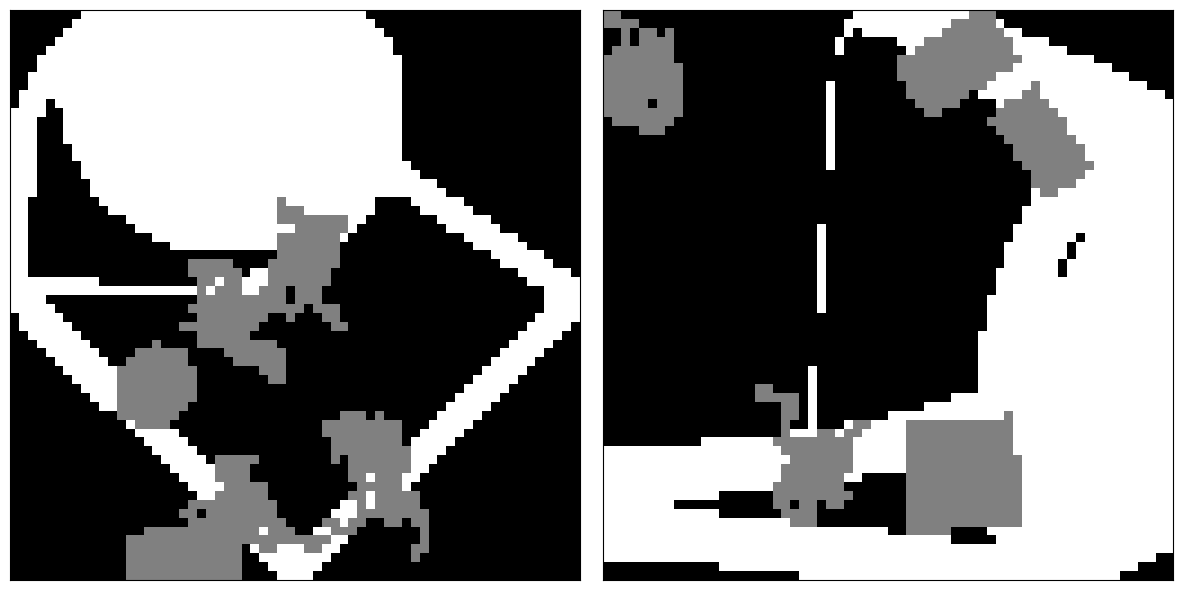

In [22]:
masked_topologies_submission = np.load("masked_topologies_submission.npy")
random_indices = np.random.choice(range(len(masked_topologies_submission)), 2)
plot_n_topologies(masked_topologies_submission[random_indices])

We pass them into our model to reconstruct (replace with your implementation here). We then binarize:

In [23]:
reconstructions_submission = reconstruct_from_model(model, masked_topologies_submission, device) #Reconstruct
reconstructions_submission = np.round(reconstructions_submission).astype(bool)

We can visualize the reconstructions to double everything looks right:

<Figure size 640x480 with 0 Axes>

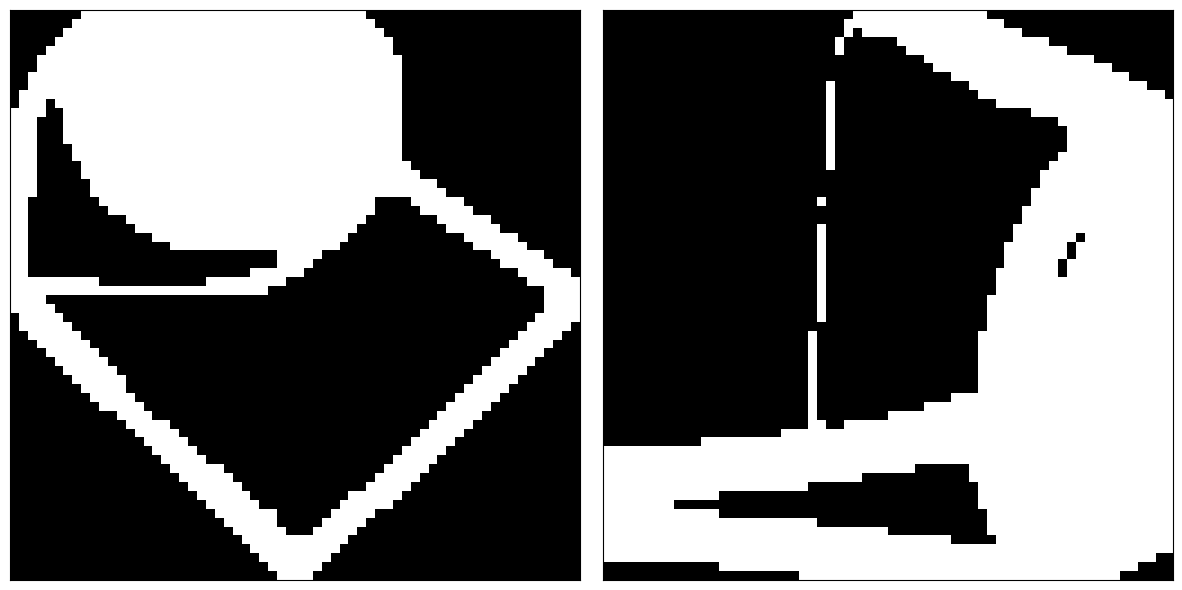

In [24]:
plot_n_topologies(reconstructions_submission[random_indices])

Assert everything is in the right shape:

In [25]:
assert reconstructions_submission.shape == (1200,64,64)
assert reconstructions_submission.dtype == bool

And we save our numpy array. Remember to download it if you run in colab.

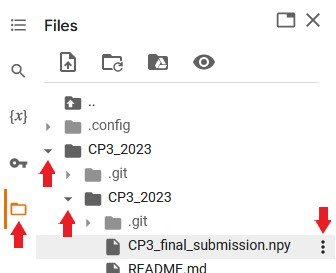

In [26]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np

# Assuming reconstructions_submission is your numpy array
np.save(f'/content/drive/MyDrive/CP3/CP3_final_submission_{score}.npy', reconstructions_submission)

Mounted at /content/drive


NameError: ignored

In [ ]:
#np.save("CP3_final_submission.npy", reconstructions_submission)

**THIS IS A FINAL REMINDER NOT TO SUBMIT THE TEST SET PREDICTIONS AS YOUR FINAL SUBMISSION**

**Some Notes:**

As with previous challenge problems, you can use whatever resources you like. These include, but are not limited to: Pretrained models, outside datasets, chatGPT, manual labeling (please don't tho), etc.

Some random links/references that are relevant:

https://openaccess.thecvf.com/content_cvpr_2018/papers/Yu_Generative_Image_Inpainting_CVPR_2018_paper.pdf

https://arxiv.org/pdf/1611.07004.pdf

https://arxiv.org/pdf/2208.09591.pdf

https://arxiv.org/pdf/2003.04685.pdf


